In [16]:
import sys
import os

# Agrega el directorio padre (la raíz del proyecto) al sys.path
sys.path.append(os.path.abspath('..'))

import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import pandas as pd
import os
import random
import logging

from data.dataloader import DataLoader


In [17]:
import logging

# Remover todos los handlers existentes
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')



[2025-02-21 19:12:22] INFO: Logging level: INFO


In [18]:

def load_single_image_and_points(img_path, mat_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    kpts = np.array(sio.loadmat(mat_path)['pts_coord'])
    return img, kpts

def delaunay_triangulation(kpts):
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def simple_spatial_matching(kpts1, kpts2):
    pts1 = kpts1.T
    pts2 = kpts2.T
    cost_matrix = distance.cdist(pts1, pts2, metric="euclidean")
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    return matching

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1
    composite_img[:h2, w1:w1+w2, :] = img2

    # Trasladar keypoints de la segunda imagen
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1

    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)
    
    # Dibujar grafos de Delaunay para ambas imágenes
    for kpts, adj_matrix, color in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2], ['r', 'b']):
        N = kpts.shape[1]
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], color+'-', linewidth=1)
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)
    
    # Dibujar matching entre keypoints
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide se pinta en verde
        if r == c:
            plt.plot([x1, x2], [y1, y2], 'g-', linewidth=1)
        else:
            plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()

def evaluate_matching_precision(kpts1, matching):
    """
    Se asume que la correspondencia ideal es la diagonal de la matriz de matching.
    """
    N = kpts1.shape[1]
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_categories():
    """
    Para cada categoría:
    1. Selecciona un par aleatorio de imágenes y muestra la visualización.
    2. Recorre imágenes pareadas (por ejemplo, consecutivas) y calcula la precisión para cada par.
    3. Acumula los resultados en una lista y al finalizar genera un único CSV (results.csv) con:
         Category,Mean_Accuracy,Std_Deviation,Number_of_Images
    """
    # Instanciar el DataLoader y cargar los dataframes
    dl = DataLoader()
    dataframes = dl.load_data()
    
    overall_results = []  # Acumula los resultados globales
    for cat_name, cat_df in dataframes.items():
        if len(cat_df) < 2:
            logger.info(f"No hay suficientes imágenes en {cat_name}")
            continue
        
        # Seleccionar de forma aleatoria un par para visualización
        idx1, idx2 = random.sample(range(len(cat_df)), 2)
        row1 = cat_df.iloc[idx1]
        row2 = cat_df.iloc[idx2]
        img1, kpts1 = load_single_image_and_points(row1['img'], row1['mat'])
        img2, kpts2 = load_single_image_and_points(row2['img'], row2['mat'])
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)
        matching = simple_spatial_matching(kpts1, kpts2)
        logger.info(f"Visualizando par aleatorio para {cat_name}")
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)
        
        # Calcular la precisión para pares consecutivos
        precisions = []
        pair_indices = []
        for i in range(len(cat_df) - 1):
            row_a = cat_df.iloc[i]
            row_b = cat_df.iloc[i+1]
            img_a, kpts_a = load_single_image_and_points(row_a['img'], row_a['mat'])
            img_b, kpts_b = load_single_image_and_points(row_b['img'], row_b['mat'])
            matching_pair = simple_spatial_matching(kpts_a, kpts_b)
            prec = evaluate_matching_precision(kpts_a, matching_pair)
            precisions.append(prec)
            pair_indices.append(i)
        
        # Calcular estadísticas agregadas
        media = np.mean(precisions)
        std = np.std(precisions)
        
        # Log e información de resultados por categoría
        logger.info(f"Categoría {cat_name.capitalize()}: Precisión media = {media:.4f}, Desviación = {std:.4f}")
        logger.info(f"Resultados procesados para {cat_name} con {len(cat_df)} imágenes")
        
        # Acumular resultados globales
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(media, 4),
            "Std_Deviation": round(std, 4),
            "Number_of_Images": len(cat_df)
        })
    
    # Generar único CSV global con los datos de todas las categorías
    overall_df = pd.DataFrame(overall_results)
    overall_df.to_csv("results.csv", index=False)
    logger.info("Resultados globales guardados en results.csv")

[2025-02-21 19:12:30] INFO: Visualizando par aleatorio para car_df


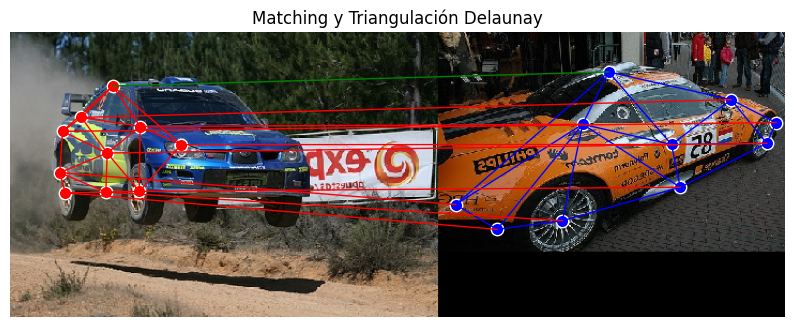

[2025-02-21 19:12:31] INFO: Categoría Car_df: Precisión media = 0.7154, Desviación = 0.2983
[2025-02-21 19:12:31] INFO: Resultados procesados para car_df con 40 imágenes
[2025-02-21 19:12:31] INFO: Visualizando par aleatorio para face_df


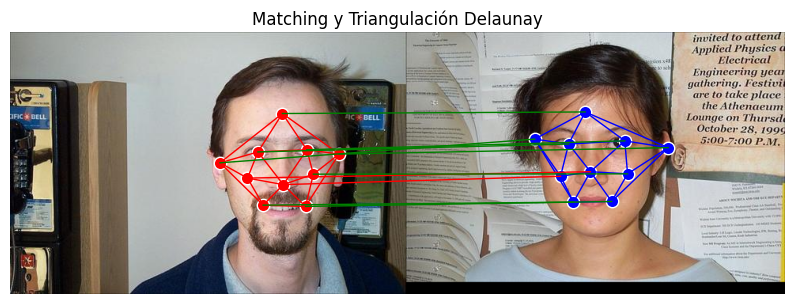

[2025-02-21 19:12:33] INFO: Categoría Face_df: Precisión media = 0.8382, Desviación = 0.1857
[2025-02-21 19:12:33] INFO: Resultados procesados para face_df con 109 imágenes
[2025-02-21 19:12:33] INFO: Visualizando par aleatorio para duck_df


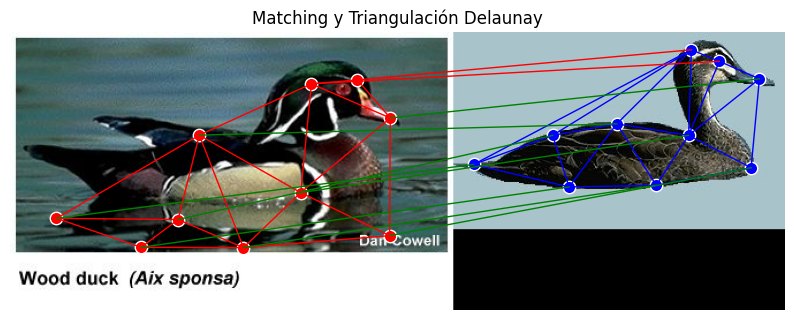

[2025-02-21 19:12:35] INFO: Categoría Duck_df: Precisión media = 0.6918, Desviación = 0.3002
[2025-02-21 19:12:35] INFO: Resultados procesados para duck_df con 50 imágenes
[2025-02-21 19:12:35] INFO: Visualizando par aleatorio para motorbike_df


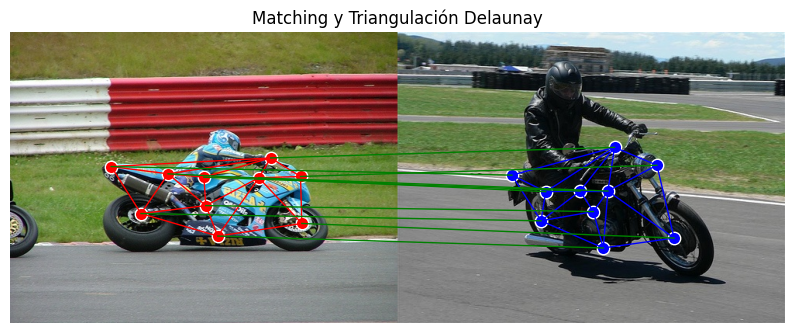

[2025-02-21 19:12:36] INFO: Categoría Motorbike_df: Precisión media = 0.8513, Desviación = 0.1693
[2025-02-21 19:12:36] INFO: Resultados procesados para motorbike_df con 40 imágenes
[2025-02-21 19:12:36] INFO: No hay suficientes imágenes en __pycache___df
[2025-02-21 19:12:36] INFO: Visualizando par aleatorio para winebottle_df


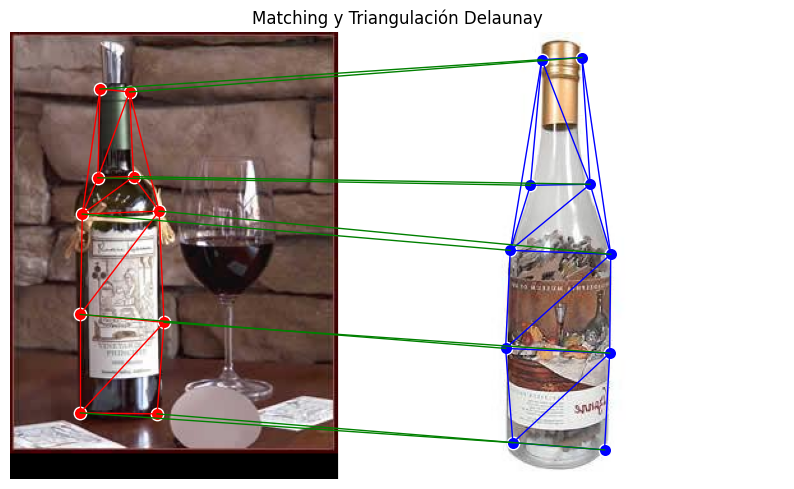

[2025-02-21 19:12:37] INFO: Categoría Winebottle_df: Precisión media = 0.8677, Desviación = 0.1930
[2025-02-21 19:12:37] INFO: Resultados procesados para winebottle_df con 66 imágenes
[2025-02-21 19:12:37] INFO: Resultados globales guardados en results.csv


In [19]:
if __name__ == "__main__":
    
    compute_precision_for_categories()

## RESULTADOS FINALES


In [20]:
resultados = pd.read_csv("results.csv")
resultados

,Category,Mean_Accuracy,Std_Deviation,Number_of_Images
0,car_df,0.7154,0.2983,40
1,face_df,0.8382,0.1857,109
2,duck_df,0.6918,0.3002,50
3,motorbike_df,0.8513,0.1693,40
4,winebottle_df,0.8677,0.1930,66
